# Voice Inpainting Debug Demo

In [18]:
import os
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
import time
from loguru import logger

from src.tokenization import AudioTokenizer
from src.semantic_edit import SemanticEditor
from src.integrated_inpainting import IntegratedVoiceInpainting
from src.main import voice_inpainting, setup_device

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Input parameters
input_file = "data/debug/2739d072-86c9-4606-9618-3f452716ebac/01_original.wav"
edit_prompt = "Change 'one piece' to 'two pieces'"
output_file = "output.wav"
debug_dir = "data/debug_output"

# Create debug directory
os.makedirs(debug_dir, exist_ok=True)

In [4]:
# Display original audio
waveform, sample_rate = torchaudio.load(input_file)
print(f"Original Audio: {input_file}")
display(Audio(waveform, rate=sample_rate))

# Run voice inpainting
fused_tokens, final_audio, final_sr = voice_inpainting(
    input_file=input_file,
    output_file=output_file,
    edits=edit_prompt,
    debug=True,
    debug_dir=debug_dir,
    temperature=0.7,
    topk=30
)

display(Audio(final_audio, rate=sample_rate))

Original Audio: data/debug/2739d072-86c9-4606-9618-3f452716ebac/01_original.wav


2025-03-29 17:56:22.922 | INFO     | src.main:voice_inpainting:73 - Debug mode enabled. Intermediate files will be saved to data/debug_output
2025-03-29 17:56:22.942 | WARNING  | src.main:setup_device:35 - MPS backend detected but not used due to compatibility issues with sparse tensors. Falling back to CPU. This will be slower but more reliable.
2025-03-29 17:56:22.942 | INFO     | src.main:setup_device:41 - Using device: cpu
2025-03-29 17:56:22.942 | INFO     | src.main:voice_inpainting:82 - Tokenizing input audio to RVQ tokens...
2025-03-29 17:56:22.943 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 17:56:23.058 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 17:56:23.058 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 17:56:23.258 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models

ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 142738.09it/s]
2025-03-29 18:00:50.783 | INFO     | src.integrated_inpainting:_initialize_csm_model:54 - CSM model loaded successfully
2025-03-29 18:00:50.784 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 18:00:50.785 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 18:00:50.785 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 18:00:50.910 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 18:00:50.940 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 18:00:51.086 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:61 - moshi_mlx initialization complete
2025-03-29 18:00:51.086 | INFO     | src.tokenization:_initialize_tokenizers:76 - Initializing Llama text t

In [5]:
edits=edit_prompt

start_time = time.time()

# Set up device
device = setup_device()

# Step 1: Tokenize input audio to RVQ tokens
logger.info("Tokenizing input audio to RVQ tokens...")
tokenizer = AudioTokenizer(device=device)
tokenized_audio = tokenizer.tokenize(input_file)

# Step 2: Process the edits - either convert a single prompt to an edit operation
#         or use the provided list of edits
edit_operations = []

if isinstance(edits, str):
    # Single edit prompt provided - use SemanticEditor to find edit region
    logger.info(f"Processing single edit prompt: {edits}")
    editor = SemanticEditor(tokenizer, load_llm=True)
    edit_op = editor.find_edit_region(tokenized_audio, edits)
    edit_operations.append(edit_op)

2025-03-29 20:31:24.816 | WARNING  | src.main:setup_device:35 - MPS backend detected but not used due to compatibility issues with sparse tensors. Falling back to CPU. This will be slower but more reliable.
2025-03-29 20:31:24.818 | INFO     | src.main:setup_device:41 - Using device: cpu
2025-03-29 20:31:24.819 | INFO     | __main__:<module>:9 - Tokenizing input audio to RVQ tokens...
2025-03-29 20:31:24.819 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 20:31:24.820 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 20:31:24.821 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 20:31:24.982 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 20:31:25.002 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 20:31:25.426 | I

In [7]:
edit_operations[0]

EditOperation(original_text='one piece', edited_text='two pieces', start_token_idx=17, end_token_idx=30, confidence=1.0, prepadding_text='I would like to have', prepadding_start_token_idx=6, prepadding_end_token_idx=17, postpadding_text='of chocolate as well as a strawberry cake.', postpadding_start_token_idx=30, postpadding_end_token_idx=62)

In [84]:
edit_operations[0].edited_text = 'two pieces'

In [86]:
tokenized_audio.text[tokenized_audio.token_to_text_map[17]:tokenized_audio.token_to_text_map[30]]

'one piece of ch'

In [65]:
tokenized_audio.text[32:]

'of chocolate as well as a strawberry cake. Thank you.'

In [66]:
tokenized_audio.text_to_token_map[32]

27

In [83]:
tokenized_audio.text[tokenized_audio.token_to_text_map[17]:tokenized_audio.token_to_text_map[27]]

'one piece '

In [ ]:
edit_operations[0].end_token_idx=27

In [85]:
temperature=0.7
topk=25

# Step 3: Perform integrated inpainting
logger.info("Performing integrated voice inpainting...")
inpainting = IntegratedVoiceInpainting(device=device)

with torch.inference_mode():
    if len(edit_operations) == 1:
        # Process single edit
        inpainted_tokens, final_audio, final_sr = inpainting.inpaint(
            tokenized_audio, 
            edit_operations[0],
            temperature=temperature,
            topk=topk
        )
    else:
        # Process multiple edits
        inpainted_tokens, final_audio, final_sr = inpainting.batch_inpaint(
            tokenized_audio,
            edit_operations,
            temperature=temperature,
            topk=topk
        )

    elapsed_time = time.time() - start_time
    logger.info(
        f"Voice inpainting completed successfully in {elapsed_time:.2f} seconds"
    )

display(Audio(final_audio, rate=final_sr))

2025-03-29 21:05:46.681 | INFO     | __main__:<module>:5 - Performing integrated voice inpainting...
2025-03-29 21:05:46.682 | INFO     | src.integrated_inpainting:_initialize_csm_model:49 - Initializing CSM model...
2025-03-29 21:06:06.636 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 21:06:06.640 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 21:06:06.771 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 21:06:06.818 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 21:06:12.639 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:61 - moshi_mlx initialization complete


ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 38947.11it/s]
2025-03-29 21:06:14.228 | INFO     | src.integrated_inpainting:_initialize_csm_model:54 - CSM model loaded successfully
2025-03-29 21:06:14.229 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 21:06:14.229 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 21:06:14.229 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 21:06:14.354 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 21:06:14.379 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 21:06:15.270 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:61 - moshi_mlx initialization complete
2025-03-29 21:06:15.271 | INFO     | src.tokenization:_initialize_tokenizers:76 - Initializing Llama text to

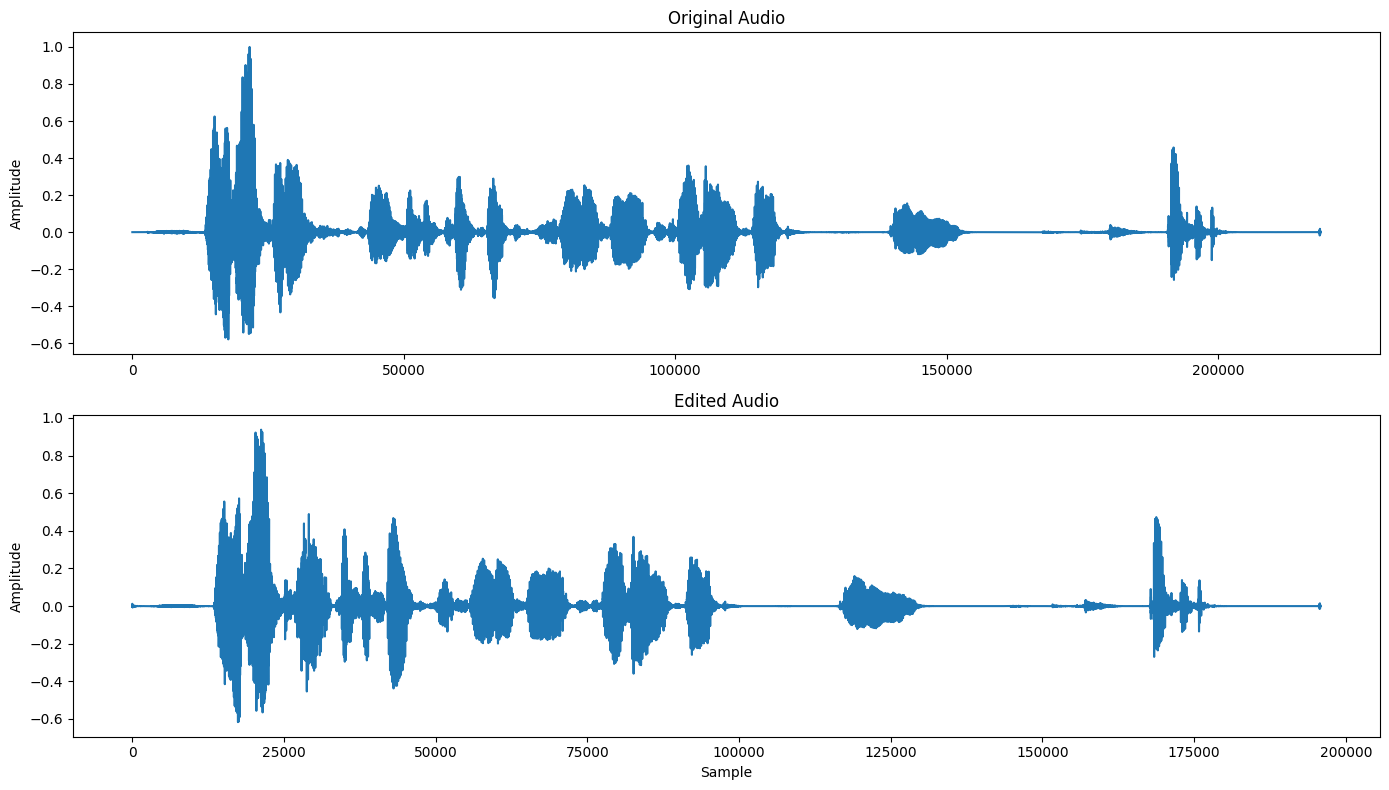

In [66]:
# Plot waveforms for comparison
plt.figure(figsize=(14, 8))

# Original audio
plt.subplot(2, 1, 1)
plt.plot(waveform[0].numpy())
plt.title("Original Audio")
plt.ylabel("Amplitude")

# Edited audio
plt.subplot(2, 1, 2)
plt.plot(final_audio.numpy())
plt.title("Edited Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()